#Import data

Первым делом подключим датасет, который содержит в себе данные с [basketball-reference.com](https://www.basketball-reference.com/). В нем есть 4 типа статистики - статистика регулярного сезона, статистика расширенного сезона, статистика команды и статистика голосования за MVP.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/NBA_Dataset.csv')
df = df.fillna(0)

# Feature Engineering and Data Preprocessing


Теперь надо приступить к feature engineering. Также нужно добавить к данным логическое значение, которое будет обозначать, какой игрок получил награду MVP в этом году. Такое значение будет у одного игрока, получившего награду. У остальных его не будет. Это позволит легко проверять, был ли наш прогноз точным.

In [ ]:
#Добавляем столбец, сообщающий нам, кто был MVP с логическим значением
mvps = df.groupby(by = "season").max('award_share')
mvps["was_mvp"] = True
df = df.merge(mvps[["award_share", "was_mvp"]], on = ["season", "award_share"], how = "left")
df["was_mvp"] = df["was_mvp"].fillna(value = False)

Теперь нужно удалить признаки, которые не добавляют никакой ценности. Некоторые данные могут быть получены из комбинации других данных. Например, fg_per_g может быть получено произведением fga_per_g на fg_pct. То есть fg_per_g можно удалить из нашего датасета.

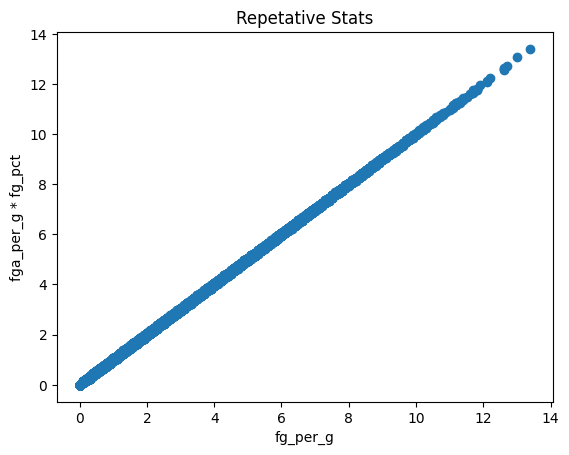

array([[1.        , 0.99990689],
       [0.99990689, 1.        ]])

In [ ]:
#график, доказывающий пример выше
plt.scatter(df["fg_per_g"], df["fga_per_g"]*df["fg_pct"])
plt.xlabel("fg_per_g")
plt.ylabel("fga_per_g * fg_pct")
plt.title("Repetative Stats")
plt.show()
np.corrcoef(df["fg_per_g"], df["fga_per_g"]*df["fg_pct"])

In [ ]:
df = df.drop(columns = ["fg_per_g", "fg3_per_g", "fg2_per_g", "ft_per_g", "trb_per_g"], axis = 1)

##Representativeness heuristic

Удалим все сезоны, которые были до появления награды MVP

In [ ]:
df = df[df["season"] > 1981]

Теперь разделим данные на train и test

In [ ]:
dfTestSet = df[df["season"] == 2022]
df =  df[df["season"] < 2022]

#Imbalanced data

Выполнена простая очистка данных, но теперь нужно бороться с несбалансированными данными. В нашем случае количество игроков, получивших голоса MVP, гораздо меньше, чем количество игроков, не получивших голосов. Таким образом, лучше сбалансировать данные, чтобы наша модель действительно изучала взаимосвязь статистики игрока с получением голосов MVP.

Существует много способов сбалансировать несбалансированный набор данных, но один из лучших способов — сначала выполнить недостаточную выборку для класса большинства, а затем использовать SMOTE для синтетического создания новых выборок в классе меньшинства.

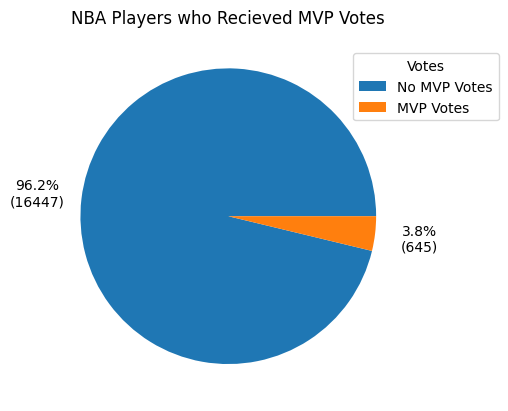

In [ ]:
from collections import Counter

classes = df["award_share"] > 0
infoDf = df[["player", "pos", "team_id"]]
dataDf = df.drop(["player", "pos", "team_id"], axis = 1)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")
ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

Один из наиболее распространенных методов недостаточной выборки называется случайной недостаточной выборкой. Здесь мы случайным образом удаляем подмножество данных из класса большинства. Хотя этот процесс может быть эффективным, его главный недостаток заключается в том, что он может удалить игроков, чья статистика может иметь значение для модели, в то время как другие игроки, имеющие избыточную статистику, останутся без информации.

Таким образом, лучший способ недооценить класс большинства — это удалить игроков, у которых очень низкий шанс получить голоса. Например, мы можем удалить игроков, которые набирают очень мало очков, игроков, которые начинают очень мало игр, и игроков, которые играют очень мало минут.

Можно сделать вывод, что игрок должен начать достаточное количество игр в течение сезона, чтобы считаться MVP. Наименьшее количество игр, начатых для игрока, чтобы получить награду MVP, было 49 игр Карла Мэлоуна в сезоне 1998-1999, который также был одной из самых спорных гонок MVP в истории НБА. Посмотрев на распределение игр, начатых игроками, получившими голоса MVP, по сравнению с теми, кто этого не сделал, можно с уверенностью предположить, что для участия в голосовании за MVP необходимо начать как минимум 20 игр.

In [ ]:
mvpShares = df[df["award_share"] > 0]
nonMvpShares = df[df["award_share"] == 0]

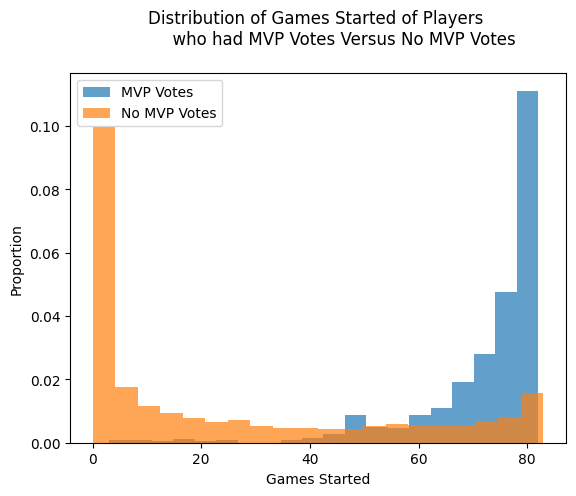

In [ ]:
plt.hist(mvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["gs"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Games Started")
plt.title("""Distribution of Games Started of Players 
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

In [ ]:
mvpShares[mvpShares["gs"] < 20][["season", "player", "g", "gs", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,g,gs,pts_per_g,award_share
0,1982,Michael Cooper,76,14,11.9,0.004
1,1991,Kevin McHale,68,10,18.4,0.001
2,1992,Detlef Schrempf,80,4,17.3,0.001
3,1995,Michael Jordan,17,17,26.9,0.011
4,1996,Magic Johnson,32,9,14.6,0.007
5,1999,Darrell Armstrong,50,15,13.8,0.002
6,1999,Rasheed Wallace,49,18,12.8,0.001
7,2021,Derrick Rose,50,3,14.7,0.010


Когда мы удаляем игроков, сыгравших менее 20 игр, мы уменьшаем размер данных до 7 132, что составляет примерно 2/5 нашего исходного набора данных. Поскольку мы исключили только 8 игроков, получивших голоса MVP, мы удалили 9 952 игрока, которые не начали достаточно игр, чтобы считаться MVP. Это здорово, но наш набор данных все еще очень несбалансирован.

In [ ]:
df = df[df["gs"] > 20]
df = df.reset_index(drop = True)
len(df)

7132

Чтобы получить награду MVP, кажется логичным, что игрок должен проводить много времени на паркете. То есть можно удалить из рассмотрения игроков с малым количеством игрового времени. 

Для поиска "временной отсечки" будем использовать третье стандартное отклонение.

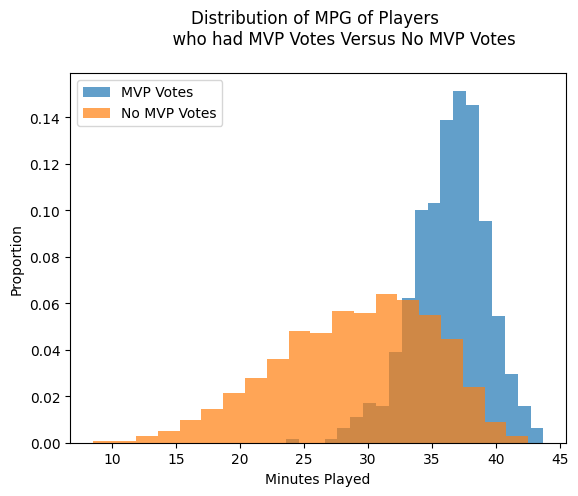

The cutoff is 27.890 minutes per game


In [ ]:
mvpShares = df[df["award_share"] > 0]
nonMvpShares = df[df["award_share"] == 0]

plt.hist(mvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["mp_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.ylabel("Proportion")
plt.xlabel("Minutes Played")
plt.title("""Distribution of MPG of Players 
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

mp_cutoff = mvpShares["mp_per_g"].mean() - 3*mvpShares["mp_per_g"].std()
print(f"The cutoff is {mp_cutoff:.3f} minutes per game")

Мы удалили только двух игроков, получивших голоса MVP - Элтон Листер и Арвидас Сабонис. Кажется, что оба этих игрока являются исключениями, получившими очень маленькое количество голосов.

In [ ]:
mvpShares[mvpShares["mp_per_g"] < mp_cutoff][["season", "player", "mp_per_g", "pts_per_g", 'award_share']].reset_index(drop = True)

,season,player,mp_per_g,pts_per_g,award_share
0,1983,Alton Lister,23.6,8.4,0.007
1,1999,Arvydas Sabonis,27.0,12.1,0.003


Тоже самое мы можем сделать и с очками, потому что, очевидно, наиболее ценный игрок должен набирать добротное количество очков за матч.

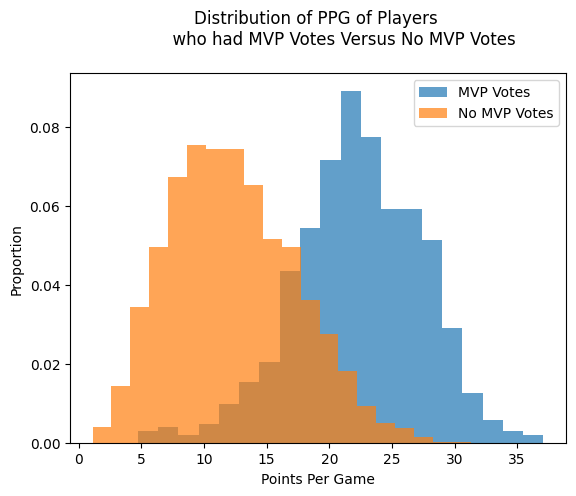

The cutoff is 7.092 points in a game


In [ ]:
plt.hist(mvpShares["pts_per_g"], bins = 20, alpha = 0.7, density=True, label = "MVP Votes")
plt.hist(nonMvpShares["pts_per_g"], bins = 20, alpha = 0.7, density=True, label = "No MVP Votes")
plt.xlabel("Points Per Game")
plt.ylabel("Proportion")
plt.title("""Distribution of PPG of Players 
          who had MVP Votes Versus No MVP Votes
          """)
plt.legend()
plt.show()

pts_cutoff = mvpShares["pts_per_g"].mean() - 3 * mvpShares["pts_per_g"].std()
print(f"The cutoff is {pts_cutoff:.3f} points in a game")

Здесь мы снова отрезали еще 4ых игроков, получивших голоса MVP. В эру центровых они славились мощной защитой и подборами. Также были удалены игроки, которые славились не количеством победных очков, а своей защитой.

In [ ]:
mvpShares[mvpShares["pts_per_g"] < pts_cutoff][["season", "player", "pts_per_g", 'blk_per_g', 'orb_per_g', 'drb_per_g', 'award_share']].reset_index(drop = True)


,season,player,pts_per_g,blk_per_g,orb_per_g,drb_per_g,award_share
0,1989,Mark Eaton,6.2,3.8,2.8,7.5,0.004
1,1994,Dennis Rodman,4.7,0.4,5.7,11.6,0.001
2,1996,Dennis Rodman,5.5,0.4,5.6,9.3,0.004
3,2003,Ben Wallace,6.9,3.2,4.0,11.4,0.028


После этих отсечек мы можем уменьшить размер датасета еще на 1000 значений.

In [ ]:
df = df[(df["pts_per_g"] > pts_cutoff) & (df["mp_per_g"] > mp_cutoff)].reset_index(drop = True)

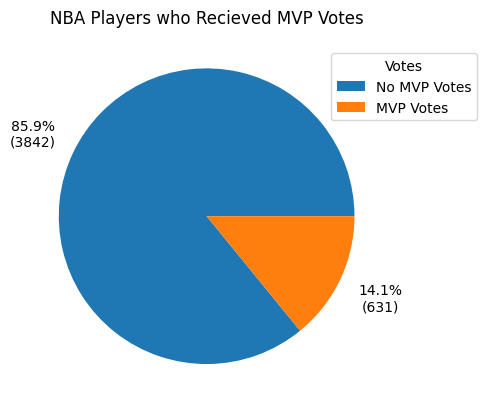

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

classes = df["award_share"] > 0

dataDf = df.drop(["player", "pos", "team_id", "was_mvp"], axis = 1)
unSmoteLen = len(dataDf)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 1.3)

ax.set_title("NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

Теперь пора применять SMOTE.

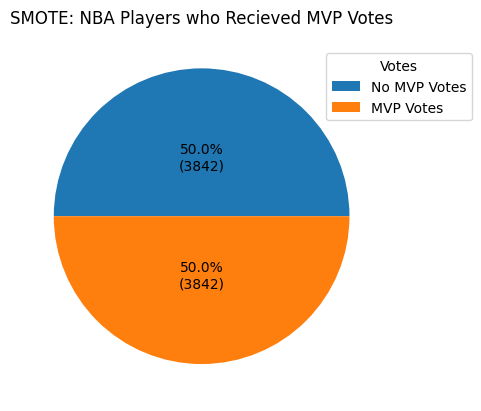

In [ ]:
smote = SMOTE(sampling_strategy = 1)
dataDf, classes = smote.fit_resample(dataDf, classes)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(classes.value_counts(), 
       autopct = lambda pct: func(pct, classes.value_counts()),
       pctdistance = 0.4)

ax.set_title("SMOTE: NBA Players who Recieved MVP Votes")

ax.legend(["No MVP Votes", "MVP Votes"],
          title="Votes",
          loc = 'center right',
           bbox_to_anchor=(1.25, 0.85))

plt.show()

Теперь данные сбалансированны, но появилась проблема - наши синтетические данные могут быть лучше, чем истинный MVP того года, хотя эти данные и не принадлежат настоящему игроку.

Добавим метки, обозначающие, какие данные являются синтетическими, а какие нет.

Сделать это легко, потому что SMOTE добавляет синтетические данные в конец датасета.

In [ ]:
dataDf["is_smote"] = dataDf.index >= unSmoteLen

In [ ]:
labeledDataDf = dataDf.merge(df, how = "left")

#The Boruta Method

Теперь у нас есть сбалансированный датасет. Теперь нужно убедиться, что данные, которые мы вводим, не являются просто шумом.

Не вся статистика NBA одинакова. Например, передачи за игру менее ценны, чем очки за игру для прогнозирования MVP. Важно не чтобы было много данных, а чтобы эти данные были полезны. 

Таким образом, нужно выбрать показатели статистики, которые наиболее важны для нашей модели.

Чтобы отбирать признаки, будет использовать метод Боруты.

In [ ]:
!pip install Boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
# from boruta import BorutaPy
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np

# rf = RandomForestRegressor(max_depth = 5, n_jobs=-1, n_estimators=500, oob_score=True)
# trans = BorutaPy(rf, n_estimators = "auto", random_state=42, verbose=2)
# selector = trans.fit(dataDf.drop(["award_share", "season", "is_smote"],axis= 1).to_numpy(), 
#                      dataDf["award_share"].to_numpy())
columns = ['age', 'g', 'gs', 'mp_per_g', 'fga_per_g', 'fg_pct',
       'fg2a_per_g', 'fg2_pct', 'efg_pct', 'fta_per_g', 'ft_pct', 'drb_per_g',
       'ast_per_g', 'stl_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'mp',
       'per', 'ts_pct', 'fta_per_fga_pct', 'drb_pct', 'trb_pct', 'ast_pct',
       'stl_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48',
       'obpm', 'dbpm', 'bpm', 'vorp', 'mov', 'win_loss_pct']

In [ ]:
#columns = dataDf.drop(["award_share", "season", "is_smote"],axis= 1).columns[selector.ranking_ <= 2]

#Data Preprocessing

После того, как мы разобрались с "грязными" данными, нужно разделить выборку на обучающую и тестовую.

In [ ]:
dfTestSet = dfTestSet[(dfTestSet["gs"] > 20) & (dfTestSet["pts_per_g"] > pts_cutoff) & (dfTestSet["mp_per_g"] > mp_cutoff)].reset_index(drop = True)

In [ ]:
from pandas.core.dtypes.common import validate_all_hashable

# Shuffling the data
modelDf = labeledDataDf.sample(frac=1).reset_index(drop = True)

# Train Data
trainInfo = modelDf[["season", "player", "pos", "team_id","award_share",  "was_mvp", "is_smote"]]
trainData = modelDf[columns]
trainTargets = modelDf[["award_share"]]

# Test Data
testInfo = dfTestSet[["season", "player", "pos", "team_id", "award_share", "was_mvp"]]
testData = dfTestSet[columns]
testTargets = dfTestSet[["award_share"]]

#Random Forest Model_default method

Model for all seasons

In [ ]:
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = RandomForestRegressor(max_depth = 7, random_state=0)
  regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])


  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  player = valInfo.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")
  
  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["was_top_two"].append(was_top_three)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2019


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01719420391442131
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
7305    2019  Giannis Antetokounmpo  PF     MIL        0.932    True     False
6715    2019           James Harden  PG     HOU        0.768   False     False
4360    2019           Nikola Jokić   C     DEN        0.210   False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.7640693381607566
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014932012503291613
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
2919    1993   Michael Jordan  SG     CHI        0.577   False     False
1611    1993  Charles Barkley  PF     PHO        0.852    True     False
6646    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6653978125184963
Was MVP correct: False


Season: 1991


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012315542895450435
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
4249    1991  Michael Jordan  SG     CHI        0.928    True     False
7544    1991  David Robinson   C     SAS        0.496   False     False
1116    1991   Magic Johnson  PG     LAL        0.518   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8112427911861617
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01251865324197377
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7472    1996     Michael Jordan  SG     CHI        0.986    True     False
2424    1996     David Robinson   C     SAS        0.508   False     False
588     1996  Anfernee Hardaway  PG     ORL        0.319   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9016819786212521
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013382475998842545
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1798    1987   Magic Johnson  PG     LAL        0.940    True     False
901     1987      Larry Bird  SF     BOS        0.347   False     False
5974    1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.6747760505798714
Was MVP correct: True


Season: 2017


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02466499464866858
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
2150    2017  Russell Westbrook  PG     OKC        0.879    True     False
2931    2017       James Harden  PG     HOU        0.746   False     False
6367    2017      Kawhi Leonard  SF     SAS        0.495   False     False
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.5931055114403686
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016864547168235933
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4831    2015  Stephen Curry  PG     GSW        0.922    True     False
2446    2015   James Harden  SG     HOU        0.720   False     False
3420    2015  Anthony Davis  PF     NOP        0.156   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.5937492774899511
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.00944901571057967
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4614    2000  Shaquille O'Neal   C     LAL        0.998    True     False
1616    2000       Karl Malone  PF     UTA        0.258   False     False
4933    2000     Kevin Garnett  PF     MIN        0.337   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9488342059660327
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013159309564295056
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
730     2009   LeBron James  SF     CLE        0.969    True     False
2286    2009    Dwyane Wade  SG     MIA        0.562   False     False
5507    2009  Dwight Howard   C     ORL        0.271   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9129637668352106
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013363908947109334
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3820    1997  Michael Jordan  SG     CHI        0.832   False     False
1979    1997     Karl Malone  PF     UTA        0.857    True     False
5825    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8496395908994271
Was MVP correct: False


Season: 2008


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.024159406427239422
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3312    2008  LeBron James  SF     CLE        0.348   False     False
130     2008    Chris Paul  PG     NOH        0.710   False     False
6985    2008   Kobe Bryant  SG     LAL        0.873    True     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5571566368001176
Was MVP correct: False


Season: 2011


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015843682409227552
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6608    2011   Derrick Rose  PG     CHI        0.977    True     False
1950    2011   LeBron James  SF     MIA        0.431   False     False
115     2011  Dwight Howard   C     ORL        0.531   False     False
Predicted MVP: Derrick Rose
Predicted Win Share: 0.7057497995536994
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.022603846994893102
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
4424    2005         Steve Nash  PG     PHO        0.839    True     False
1124    2005  Amar'e Stoudemire   C     PHO        0.032   False     False
439     2005       LeBron James  SF     CLE        0.073   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.5316252560171164
Was MVP correct: True


Season: 2012


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.021447358461181183
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
7106    2012  LeBron James  SF     MIA        0.888    True     False
3028    2012  Kevin Durant  SF     OKC        0.735   False     False
5017    2012  Derrick Rose  PG     CHI        0.004   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6407619785395814
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01434007971032541
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
224     1983   Moses Malone   C     PHI        0.960    True     False
7221    1983     Larry Bird  PF     BOS        0.485   False     False
2457    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.6777701098424221
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013251016098331417
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
897     1992  Michael Jordan  SG     CHI        0.938    True     False
4390    1992     Karl Malone  PF     UTA        0.273   False     False
458     1992   Clyde Drexler  SG     POR        0.584   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8818403649591855
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012713348527374267
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
411     1989  Michael Jordan  SG     CHI        0.704   False     False
3225    1989   Magic Johnson  PG     LAL        0.782    True     False
7675    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7320456394408253
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02280435436480757
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1546    1999       Karl Malone  PF     UTA        0.701    True     False
2423    1999  Shaquille O'Neal   C     LAL        0.075   False     False
5609    1999   Alonzo Mourning   C     MIA        0.655   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.26480415697929394
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014184717206736617
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
754     2010   LeBron James  SF     CLE        0.980    True     False
821     2010   Kevin Durant  SF     OKC        0.495   False     False
3767    2010  Dwight Howard   C     ORL        0.389   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9127775069557735
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.021682751585739027
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1287    2001     Allen Iverson  SG     PHI        0.904    True     False
3994    2001  Shaquille O'Neal   C     LAL        0.466   False     False
2718    2001        Tim Duncan  PF     SAS        0.569   False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.5374201384272523
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011983794572209378
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
325     2013  LeBron James  PF     MIA        0.998    True     False
992     2013  Kevin Durant  SF     OKC        0.632   False     False
5738    2013    Chris Paul  PG     LAC        0.239   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8687664134332185
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015160404363687008
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
7194    2014  Kevin Durant  SF     OKC        0.986    True     False
2567    2014  LeBron James  PF     MIA        0.713   False     False
2489    2014    Kevin Love  PF     MIN        0.020   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.8026128895198491
Was MVP correct: True


Season: 2006


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.025356586021748874
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1438    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
6832    2006   LeBron James  SF     CLE        0.550   False     False
1189    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.5794104127126373
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.009911041904450612
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6624    1995    David Robinson   C     SAS        0.858    True     False
7410    1995       Karl Malone  PF     UTA        0.507   False     False
4723    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7918043535059348
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01441129949308771
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7037    1986         Larry Bird  SF     BOS        0.981    True     False
164     1986      Magic Johnson  PG     LAL        0.263   False     False
7266    1986  Dominique Wilkins  SF     ATL        0.522   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7529706496553484
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016692525835546097
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3022    1984      Larry Bird  PF     BOS        0.858    True     False
2636    1984   Magic Johnson  PG     LAL        0.401   False     False
4493    1984  Adrian Dantley  SF     UTA        0.116   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.5581096221704088
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01214417478203241
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1752    1985      Larry Bird  SF     BOS        0.978    True     False
3612    1985   Magic Johnson  PG     LAL        0.338   False     False
1443    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7346333894078725
Was MVP correct: True


Season: 2018


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018883325874634246
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1052    2018   James Harden  SG     HOU        0.955    True     False
2049    2018   LeBron James  PF     CLE        0.731   False     False
2011    2018  Anthony Davis  PF     NOP        0.441   False     False
Predicted MVP: James Harden
Predicted Win Share: 0.7277731688114963
Was MVP correct: True


Season: 2021


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01882625367164558
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3745    2021           Nikola Jokić   C     DEN        0.961    True     False
4264    2021  Giannis Antetokounmpo  PF     MIL        0.345   False     False
4438    2021          Stephen Curry  PG     GSW        0.449   False     False
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.866389037390362
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016036437822028227
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5016    2003     Tim Duncan  PF     SAS        0.808    True     False
3581    2003  Tracy McGrady  SG     ORL        0.359   False     False
3074    2003  Dirk Nowitzki  PF     DAL        0.036   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6871912417487667
Was MVP correct: True


Season: 2007


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01746702976018116
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
7493    2007     Steve Nash  PG     PHO        0.785   False     False
2510    2007  Dirk Nowitzki  PF     DAL        0.882    True     False
1699    2007   LeBron James  SF     CLE        0.142   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.5823984346096639
Was MVP correct: False


Season: 1998


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012168591287466168
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
4999    1998     Karl Malone  PF     UTA        0.726   False     False
5222    1998  Michael Jordan  SG     CHI        0.934    True     False
7299    1998  David Robinson   C     SAS        0.031   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.7085614296296281
Was MVP correct: False


Season: 1994


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015045546379251741
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5546    1994    David Robinson   C     SAS        0.723   False     False
6315    1994   Hakeem Olajuwon   C     HOU        0.880    True     False
7310    1994  Shaquille O'Neal   C     ORL        0.286   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7661221419636073
Was MVP correct: False


Season: 2002


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018213397161384755
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6925    2002        Tim Duncan  PF     SAS        0.757    True     False
7141    2002        Jason Kidd  PG     NJN        0.712   False     False
5803    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.5629310342672648
Was MVP correct: True


Season: 1990


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019498750819522986
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5316    1990   Michael Jordan  SG     CHI        0.613   False     False
7159    1990    Magic Johnson  PG     LAL        0.691    True     False
7259    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7243189499101288
Was MVP correct: False


Season: 2004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01688655819314001
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1761    2004     Kevin Garnett  PF     MIN        0.991    True     False
4361    2004        Tim Duncan  PF     SAS        0.582   False     False
5437    2004  Shaquille O'Neal   C     LAL        0.145   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.7248407893799876
Was MVP correct: True


Season: 2016


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015829685126958596
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
852     2016  Stephen Curry  PG     GSW        1.000    True     False
6676    2016   Kevin Durant  SF     OKC        0.112   False     False
3322    2016   LeBron James  SF     CLE        0.482   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.8406365013285096
Was MVP correct: True


Season: 2020


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01630722847527696
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3813    2020           LeBron James  PG     LAL        0.746   False     False
3574    2020  Giannis Antetokounmpo  PF     MIL        0.952    True     False
5666    2020           James Harden  SG     HOU        0.363   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5066174881715131
Was MVP correct: False


Season: 1982


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018983363474200116
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3857    1982  Julius Erving  SF     PHI        0.294   False     False
4810    1982   Moses Malone   C     HOU        0.735    True     False
1496    1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Julius Erving
Predicted Win Share: 0.35400120500166177
Was MVP correct: False


Season: 1988
MAE: 0.014170620934204504
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5122    1988  Michael Jordan  SG     CHI        0.831    True     False
6199    1988      Larry Bird  SF     BOS        0.659   False     False
5605    1988   Magic Johnson  PG     LAL        0.635   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7265518501271768
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The Random Forest Model predicted the NBA MVP correctly 0.725% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.975% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.975% of the time


Подбор гиперпараметров с помощью optuna для какого-то одного сезона

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
#предсказываем для seasons[-20] без оптуны
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
#какой-то случайный сезон
season = seasons[-20]
print("\n")
print(f"Season: {season}")

trainFold = trainData[trainInfo["season"] != season]
trainTarFold = trainTargets[trainInfo["season"] != season]
valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

regr = RandomForestRegressor(max_depth = 7, random_state=0)
regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

valPred = regr.predict(valFold)
mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

print(f"MAE: {mae}")

topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
was_top_two = sum(topTwo["was_mvp"]) > 0
topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
was_top_three = sum(topThree["was_mvp"]) > 0
print("Predicted top three players in MVP voting with their actual award_share:")
print(topThree.iloc[::-1])


mostVotes = np.argmax(valPred)
score = np.amax(valPred)
was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
player = valInfo.iloc[[mostVotes]]["player"].values[0]
print(f"Predicted MVP: {player}")
print(f"Predicted Win Share: {score}")
print(f"Was MVP correct: {was_mvp}")
 
validation_scores["season"].append(season)
validation_scores["mae"].append(mae)
validation_scores["was_mvp"].append(was_mvp)
validation_scores["was_top_two"].append(was_top_three)
validation_scores["was_top_three"].append(was_top_three)
validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2013
MAE: 0.011983794572209378
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
325     2013  LeBron James  PF     MIA        0.998    True     False
992     2013  Kevin Durant  SF     OKC        0.632   False     False
5738    2013    Chris Paul  PG     LAC        0.239   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.8687664134332185
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
#подбор гиперпараметров с помощью оптуны
import sklearn
from sklearn.ensemble import RandomForestRegressor
import optuna

def object(trial):
  seasons = trainInfo.season.unique()
#какой-то случайный сезон
  season = seasons[-20]
  print("\n")
  print(f"Season: {season}")
  #гиперпараметры
  n_est = trial.suggest_int('n_estimators', 2, 20)
  max_depth = trial.suggest_int('max_depth', 1, 32, log=True)
  min_split = trial.suggest_int('min_split', 2, 10)
  min_leaf = trial.suggest_int('min_leaf', 1, 10)
  #данные
  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  #модель
  regr = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, min_samples_leaf=min_leaf, min_samples_split=min_split)
  #return sklearn.model_selection.cross_val_score(regr, trainFold, trainTarFold, n_jobs=-1, cv=3).mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))
  return sklearn.model_selection.cross_val_score(regr, trainFold, trainTarFold, n_jobs=-1, cv=3).mean()


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(object, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print('Best hyperparametrs: {}'.format(trial.params))

[I 2023-05-15 11:51:59,360] A new study created in memory with name: no-name-cefd5aa6-207d-4694-9f0d-948e79fe2e9c




Season: 2013


[I 2023-05-15 11:52:05,092] Trial 0 finished with value: 0.8105662126090188 and parameters: {'n_estimators': 9, 'max_depth': 25, 'min_split': 6, 'min_leaf': 10}. Best is trial 0 with value: 0.8105662126090188.




Season: 2013


[I 2023-05-15 11:52:16,927] Trial 1 finished with value: 0.8547453504691037 and parameters: {'n_estimators': 19, 'max_depth': 17, 'min_split': 10, 'min_leaf': 3}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:18,293] Trial 2 finished with value: 0.7764817477919772 and parameters: {'n_estimators': 5, 'max_depth': 6, 'min_split': 3, 'min_leaf': 7}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:22,045] Trial 3 finished with value: 0.849919561958539 and parameters: {'n_estimators': 6, 'max_depth': 27, 'min_split': 4, 'min_leaf': 1}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:25,267] Trial 4 finished with value: 0.8321135878900661 and parameters: {'n_estimators': 5, 'max_depth': 13, 'min_split': 4, 'min_leaf': 5}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:31,647] Trial 5 finished with value: 0.8192154102160054 and parameters: {'n_estimators': 9, 'max_depth': 16, 'min_split': 6, 'min_leaf': 10}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:32,517] Trial 6 finished with value: 0.639146008912823 and parameters: {'n_estimators': 6, 'max_depth': 3, 'min_split': 8, 'min_leaf': 3}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:33,111] Trial 7 finished with value: 0.42735792778024706 and parameters: {'n_estimators': 5, 'max_depth': 1, 'min_split': 9, 'min_leaf': 3}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:36,976] Trial 8 finished with value: 0.8151235872512305 and parameters: {'n_estimators': 13, 'max_depth': 11, 'min_split': 9, 'min_leaf': 10}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:37,482] Trial 9 finished with value: 0.42416288295918453 and parameters: {'n_estimators': 15, 'max_depth': 1, 'min_split': 5, 'min_leaf': 4}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:40,684] Trial 10 finished with value: 0.7152254476000528 and parameters: {'n_estimators': 20, 'max_depth': 4, 'min_split': 10, 'min_leaf': 7}. Best is trial 1 with value: 0.8547453504691037.




Season: 2013


[I 2023-05-15 11:52:47,948] Trial 11 finished with value: 0.877394388210884 and parameters: {'n_estimators': 20, 'max_depth': 32, 'min_split': 2, 'min_leaf': 1}. Best is trial 11 with value: 0.877394388210884.




Season: 2013


[I 2023-05-15 11:52:55,953] Trial 12 finished with value: 0.8774074475108007 and parameters: {'n_estimators': 20, 'max_depth': 32, 'min_split': 2, 'min_leaf': 1}. Best is trial 12 with value: 0.8774074475108007.




Season: 2013


[I 2023-05-15 11:53:01,840] Trial 13 finished with value: 0.8817073857826072 and parameters: {'n_estimators': 17, 'max_depth': 31, 'min_split': 2, 'min_leaf': 1}. Best is trial 13 with value: 0.8817073857826072.




Season: 2013


[I 2023-05-15 11:53:08,299] Trial 14 finished with value: 0.8755957380937582 and parameters: {'n_estimators': 16, 'max_depth': 32, 'min_split': 2, 'min_leaf': 1}. Best is trial 13 with value: 0.8817073857826072.




Season: 2013


[I 2023-05-15 11:53:11,357] Trial 15 finished with value: 0.8256469348637566 and parameters: {'n_estimators': 17, 'max_depth': 7, 'min_split': 3, 'min_leaf': 2}. Best is trial 13 with value: 0.8817073857826072.




Season: 2013


[I 2023-05-15 11:53:15,026] Trial 16 finished with value: 0.8477315384194194 and parameters: {'n_estimators': 13, 'max_depth': 19, 'min_split': 2, 'min_leaf': 5}. Best is trial 13 with value: 0.8817073857826072.




Season: 2013


[I 2023-05-15 11:53:15,577] Trial 17 finished with value: 0.7694331539307256 and parameters: {'n_estimators': 2, 'max_depth': 9, 'min_split': 4, 'min_leaf': 7}. Best is trial 13 with value: 0.8817073857826072.




Season: 2013


[I 2023-05-15 11:53:22,189] Trial 18 finished with value: 0.8655058374399887 and parameters: {'n_estimators': 18, 'max_depth': 21, 'min_split': 7, 'min_leaf': 2}. Best is trial 13 with value: 0.8817073857826072.




Season: 2013


[I 2023-05-15 11:53:25,748] Trial 19 finished with value: 0.8615702040916812 and parameters: {'n_estimators': 14, 'max_depth': 12, 'min_split': 3, 'min_leaf': 2}. Best is trial 13 with value: 0.8817073857826072.


Accuracy: 0.8817073857826072
Best hyperparametrs: {'n_estimators': 17, 'max_depth': 31, 'min_split': 2, 'min_leaf': 1}


In [ ]:
print(trial.params)

{'n_estimators': 17, 'max_depth': 31, 'min_split': 2, 'min_leaf': 1}


In [ ]:
#обучение с оптимальными гиперпараметрами
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
#какой-то случайный сезон
season = seasons[-20]
print("\n")
print(f"Season: {season}")

trainFold = trainData[trainInfo["season"] != season]
trainTarFold = trainTargets[trainInfo["season"] != season]
valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

regr = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'],
                             min_samples_leaf=trial.params['min_leaf'], min_samples_split=trial.params['min_split'], random_state=0)
regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

valPred = regr.predict(valFold)
mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

print(f"MAE: {mae}")

topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
was_top_two = sum(topTwo["was_mvp"]) > 0
topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
was_top_three = sum(topThree["was_mvp"]) > 0
print("Predicted top three players in MVP voting with their actual award_share:")
print(topThree.iloc[::-1])


mostVotes = np.argmax(valPred)
score = np.amax(valPred)
was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
player = valInfo.iloc[[mostVotes]]["player"].values[0]
print(f"Predicted MVP: {player}")
print(f"Predicted Win Share: {score}")
print(f"Was MVP correct: {was_mvp}")
 
validation_scores["season"].append(season)
validation_scores["mae"].append(mae)
validation_scores["was_mvp"].append(was_mvp)
validation_scores["was_top_two"].append(was_top_three)
validation_scores["was_top_three"].append(was_top_three)
validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2013
MAE: 0.008827268509915607
Predicted top three players in MVP voting with their actual award_share:
     season           player pos team_id  award_share was_mvp  is_smote
325    2013     LeBron James  PF     MIA        0.998    True     False
992    2013     Kevin Durant  SF     OKC        0.632   False     False
333    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9129369481453434
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'],
                             min_samples_leaf=trial.params['min_leaf'], min_samples_split=trial.params['min_split'], random_state=0)
  regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])


  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  player = valInfo.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")
  
  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["was_top_two"].append(was_top_three)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2019


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01272300382934528
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
7305    2019  Giannis Antetokounmpo  PF     MIL        0.932    True     False
6715    2019           James Harden  PG     HOU        0.768   False     False
6405    2019            Paul George  SF     OKC        0.352   False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.7726018402945565
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01024967450705363
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
2919    1993   Michael Jordan  SG     CHI        0.577   False     False
6646    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
1611    1993  Charles Barkley  PF     PHO        0.852    True     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6268471937691078
Was MVP correct: False


Season: 1991


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010097812054152553
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
4249    1991  Michael Jordan  SG     CHI        0.928    True     False
7544    1991  David Robinson   C     SAS        0.496   False     False
1116    1991   Magic Johnson  PG     LAL        0.518   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8843112066958216
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.008579650617710231
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7472    1996     Michael Jordan  SG     CHI        0.986    True     False
2424    1996     David Robinson   C     SAS        0.508   False     False
588     1996  Anfernee Hardaway  PG     ORL        0.319   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9185125535924054
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011969569996184853
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1798    1987   Magic Johnson  PG     LAL        0.940    True     False
901     1987      Larry Bird  SF     BOS        0.347   False     False
5974    1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.6676930305076292
Was MVP correct: True


Season: 2017


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02104484552266395
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
2150    2017  Russell Westbrook  PG     OKC        0.879    True     False
2931    2017       James Harden  PG     HOU        0.746   False     False
6367    2017      Kawhi Leonard  SF     SAS        0.495   False     False
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.6608083560323256
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014078554949549309
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4831    2015  Stephen Curry  PG     GSW        0.922    True     False
2446    2015   James Harden  SG     HOU        0.720   False     False
1160    2015   LeBron James  SF     CLE        0.425   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.5694041080051377
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0077357172853896325
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4614    2000  Shaquille O'Neal   C     LAL        0.998    True     False
4933    2000     Kevin Garnett  PF     MIN        0.337   False     False
1616    2000       Karl Malone  PF     UTA        0.258   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9937068979567677
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010139056446440807
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
730     2009  LeBron James  SF     CLE        0.969    True     False
2286    2009   Dwyane Wade  SG     MIA        0.562   False     False
7417    2009    Chris Paul  PG     NOH        0.159   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9530499775352053
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012237695224712027
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3820    1997  Michael Jordan  SG     CHI        0.832   False     False
1979    1997     Karl Malone  PF     UTA        0.857    True     False
5825    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8445474493145477
Was MVP correct: False


Season: 2008


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.020110078435826923
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
3312    2008  LeBron James  SF     CLE        0.348   False     False
130     2008    Chris Paul  PG     NOH        0.710   False     False
6985    2008   Kobe Bryant  SG     LAL        0.873    True     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5990840347383994
Was MVP correct: False


Season: 2011


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01013340453577432
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6608    2011   Derrick Rose  PG     CHI        0.977    True     False
1950    2011   LeBron James  SF     MIA        0.431   False     False
115     2011  Dwight Howard   C     ORL        0.531   False     False
Predicted MVP: Derrick Rose
Predicted Win Share: 0.8981095306711504
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017678954630258443
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
4424    2005         Steve Nash  PG     PHO        0.839    True     False
1124    2005  Amar'e Stoudemire   C     PHO        0.032   False     False
4019    2005   Shaquille O'Neal   C     MIA        0.813   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.7079703797802211
Was MVP correct: True


Season: 2012


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016085716013447764
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
7106    2012  LeBron James  SF     MIA        0.888    True     False
3028    2012  Kevin Durant  SF     OKC        0.735   False     False
5017    2012  Derrick Rose  PG     CHI        0.004   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6235558890922802
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012895397187309426
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
224     1983   Moses Malone   C     PHI        0.960    True     False
7221    1983     Larry Bird  PF     BOS        0.485   False     False
2457    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.7329479572505924
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.00893110575111174
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
897     1992  Michael Jordan  SG     CHI        0.938    True     False
458     1992   Clyde Drexler  SG     POR        0.584   False     False
4840    1992  David Robinson   C     SAS        0.351   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8383990985215153
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012166453096161376
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
411     1989  Michael Jordan  SG     CHI        0.704   False     False
3225    1989   Magic Johnson  PG     LAL        0.782    True     False
7675    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7274951518907434
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01656622858196594
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1546    1999       Karl Malone  PF     UTA        0.701    True     False
2423    1999  Shaquille O'Neal   C     LAL        0.075   False     False
5609    1999   Alonzo Mourning   C     MIA        0.655   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.5168669251794343
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012489532811399315
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
754     2010   LeBron James  SF     CLE        0.980    True     False
821     2010   Kevin Durant  SF     OKC        0.495   False     False
3767    2010  Dwight Howard   C     ORL        0.389   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.933114543773234
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01611756833174271
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1287    2001     Allen Iverson  SG     PHI        0.904    True     False
3994    2001  Shaquille O'Neal   C     LAL        0.466   False     False
5784    2001      Chris Webber  PF     SAC        0.420   False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.6974308148114873
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.008827268509915607
Predicted top three players in MVP voting with their actual award_share:
     season           player pos team_id  award_share was_mvp  is_smote
325    2013     LeBron James  PF     MIA        0.998    True     False
992    2013     Kevin Durant  SF     OKC        0.632   False     False
333    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9129369481453434
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010202155286650144
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
7194    2014   Kevin Durant  SF     OKC        0.986    True     False
2567    2014   LeBron James  PF     MIA        0.713   False     False
6349    2014  Blake Griffin  PF     LAC        0.347   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.8578751294125234
Was MVP correct: True


Season: 2006


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.021323279663851672
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1438    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
6832    2006   LeBron James  SF     CLE        0.550   False     False
1189    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.564392220997472
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.007732289650105409
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6624    1995    David Robinson   C     SAS        0.858    True     False
7410    1995       Karl Malone  PF     UTA        0.507   False     False
4723    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.8085069868870729
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01095213546660595
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7037    1986         Larry Bird  SF     BOS        0.981    True     False
164     1986      Magic Johnson  PG     LAL        0.263   False     False
7266    1986  Dominique Wilkins  SF     ATL        0.522   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.6925066283029581
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013956688318551607
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3022    1984     Larry Bird  PF     BOS        0.858    True     False
2636    1984  Magic Johnson  PG     LAL        0.401   False     False
159     1984   Bernard King  SF     NYK        0.491   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.6349668070763634
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.009900228907830766
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1752    1985      Larry Bird  SF     BOS        0.978    True     False
3612    1985   Magic Johnson  PG     LAL        0.338   False     False
1443    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.733134131700839
Was MVP correct: True


Season: 2018


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014640828776921607
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1052    2018   James Harden  SG     HOU        0.955    True     False
2049    2018   LeBron James  PF     CLE        0.731   False     False
2011    2018  Anthony Davis  PF     NOP        0.441   False     False
Predicted MVP: James Harden
Predicted Win Share: 0.7191943610075363
Was MVP correct: True


Season: 2021


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013941122359312986
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3745    2021           Nikola Jokić   C     DEN        0.961    True     False
4438    2021          Stephen Curry  PG     GSW        0.449   False     False
4264    2021  Giannis Antetokounmpo  PF     MIL        0.345   False     False
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.9406358390208458
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014706157275874612
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5016    2003     Tim Duncan  PF     SAS        0.808    True     False
3581    2003  Tracy McGrady  SG     ORL        0.359   False     False
826     2003  Kevin Garnett  PF     MIN        0.732   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.7223719322644309
Was MVP correct: True


Season: 2007


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014422895303145587
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
7493    2007     Steve Nash  PG     PHO        0.785   False     False
2510    2007  Dirk Nowitzki  PF     DAL        0.882    True     False
1699    2007   LeBron James  SF     CLE        0.142   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.5799748034753284
Was MVP correct: False


Season: 1998


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010652677710339556
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
4999    1998     Karl Malone  PF     UTA        0.726   False     False
5222    1998  Michael Jordan  SG     CHI        0.934    True     False
7299    1998  David Robinson   C     SAS        0.031   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.711706328514634
Was MVP correct: False


Season: 1994


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01096851508380247
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5546    1994   David Robinson   C     SAS        0.723   False     False
6315    1994  Hakeem Olajuwon   C     HOU        0.880    True     False
4341    1994   Scottie Pippen  SF     CHI        0.386   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.780763454978912
Was MVP correct: False


Season: 2002


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014843764123144795
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6925    2002        Tim Duncan  PF     SAS        0.757    True     False
7141    2002        Jason Kidd  PG     NJN        0.712   False     False
5803    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.67980813274424
Was MVP correct: True


Season: 1990


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01702489179178295
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5316    1990   Michael Jordan  SG     CHI        0.613   False     False
7159    1990    Magic Johnson  PG     LAL        0.691    True     False
7259    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6915906818744343
Was MVP correct: False


Season: 2004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015424085451608482
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1761    2004     Kevin Garnett  PF     MIN        0.991    True     False
4361    2004        Tim Duncan  PF     SAS        0.582   False     False
5437    2004  Shaquille O'Neal   C     LAL        0.145   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.8202962491904913
Was MVP correct: True


Season: 2016


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014604768006394165
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
852     2016  Stephen Curry  PG     GSW        1.000    True     False
3322    2016   LeBron James  SF     CLE        0.482   False     False
6676    2016   Kevin Durant  SF     OKC        0.112   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.7672093051362457
Was MVP correct: True


Season: 2020


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013381160869255896
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3813    2020           LeBron James  PG     LAL        0.746   False     False
3574    2020  Giannis Antetokounmpo  PF     MIL        0.952    True     False
5666    2020           James Harden  SG     HOU        0.363   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6242916440379472
Was MVP correct: False


Season: 1982


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015903173355080465
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4810    1982   Moses Malone   C     HOU        0.735    True     False
3857    1982  Julius Erving  SF     PHI        0.294   False     False
1496    1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.4671950547513801
Was MVP correct: True


Season: 1988
MAE: 0.011438220616422577
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5122    1988  Michael Jordan  SG     CHI        0.831    True     False
6199    1988      Larry Bird  SF     BOS        0.659   False     False
5605    1988   Magic Johnson  PG     LAL        0.635   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7420435620094762
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The Random Forest Model predicted the NBA MVP correctly 0.75% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.975% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.975% of the time


#Random Forest Model_GridSampler method

Подбор гиперпараметров с помощью optuna для какого-то одного сезона

In [ ]:
#подбор гиперпараметров с помощью оптуны
import sklearn
from sklearn.ensemble import RandomForestRegressor
import optuna
def object(trial):
  seasons = trainInfo.season.unique()
#какой-то случайный сезон
  season = seasons[-20]
  print("\n")
  print(f"Season: {season}")
  #гиперпараметры
  n_est = trial.suggest_int('n_estimators', 2, 20)
  max_depth = trial.suggest_int('max_depth', 1, 32, log=True)
  min_split = trial.suggest_int('min_split', 2, 10)
  min_leaf = trial.suggest_int('min_leaf', 1, 10)
  #данные
  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  #модель
  regr = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, min_samples_leaf=min_leaf, min_samples_split=min_split)
  #return sklearn.model_selection.cross_val_score(regr, trainFold, trainTarFold, n_jobs=-1, cv=3).mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))
  return sklearn.model_selection.cross_val_score(regr, trainFold, trainTarFold, n_jobs=-1, cv=3).mean()


In [ ]:
search_space = {"n_estimators": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32], "min_leaf": [1,2,3,4,5,6,7,8,9,10], "min_split": [2,3,4,5,6,7,8,9,10]}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction='maximize')
study.optimize(object, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print('Best hyperparametrs: {}'.format(trial.params))

[I 2023-05-15 11:56:10,661] A new study created in memory with name: no-name-ea61a43f-44d4-4a27-a0ba-cddf0fb0daef




Season: 2013


[I 2023-05-15 11:56:11,686] Trial 0 finished with value: 0.7931881655767364 and parameters: {'n_estimators': 4, 'max_depth': 11, 'min_split': 10, 'min_leaf': 10}. Best is trial 0 with value: 0.7931881655767364.




Season: 2013


[I 2023-05-15 11:56:16,360] Trial 1 finished with value: 0.8720544214155798 and parameters: {'n_estimators': 12, 'max_depth': 21, 'min_split': 4, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:21,074] Trial 2 finished with value: 0.8708843135420752 and parameters: {'n_estimators': 16, 'max_depth': 11, 'min_split': 2, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:22,014] Trial 3 finished with value: 0.7960204357637308 and parameters: {'n_estimators': 3, 'max_depth': 19, 'min_split': 3, 'min_leaf': 8}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:23,793] Trial 4 finished with value: 0.8068270640733348 and parameters: {'n_estimators': 10, 'max_depth': 8, 'min_split': 7, 'min_leaf': 10}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:24,502] Trial 5 finished with value: 0.6528582729500129 and parameters: {'n_estimators': 7, 'max_depth': 3, 'min_split': 6, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:25,101] Trial 6 finished with value: 0.7587268690713915 and parameters: {'n_estimators': 3, 'max_depth': 6, 'min_split': 2, 'min_leaf': 4}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:31,416] Trial 7 finished with value: 0.8634920115781718 and parameters: {'n_estimators': 20, 'max_depth': 15, 'min_split': 8, 'min_leaf': 4}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:36,390] Trial 8 finished with value: 0.8564553543465744 and parameters: {'n_estimators': 19, 'max_depth': 13, 'min_split': 10, 'min_leaf': 4}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:39,982] Trial 9 finished with value: 0.8148126361678057 and parameters: {'n_estimators': 20, 'max_depth': 8, 'min_split': 7, 'min_leaf': 10}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:41,601] Trial 10 finished with value: 0.6557845220090599 and parameters: {'n_estimators': 19, 'max_depth': 3, 'min_split': 3, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:44,159] Trial 11 finished with value: 0.8027539691014205 and parameters: {'n_estimators': 10, 'max_depth': 7, 'min_split': 6, 'min_leaf': 9}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:47,271] Trial 12 finished with value: 0.8213349739324571 and parameters: {'n_estimators': 12, 'max_depth': 9, 'min_split': 8, 'min_leaf': 8}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:52,498] Trial 13 finished with value: 0.8700076659251672 and parameters: {'n_estimators': 17, 'max_depth': 16, 'min_split': 5, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:56,670] Trial 14 finished with value: 0.8600880399459623 and parameters: {'n_estimators': 12, 'max_depth': 29, 'min_split': 9, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:57,703] Trial 15 finished with value: 0.707236009729516 and parameters: {'n_estimators': 5, 'max_depth': 4, 'min_split': 5, 'min_leaf': 6}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:56:58,948] Trial 16 finished with value: 0.7913694095528174 and parameters: {'n_estimators': 2, 'max_depth': 25, 'min_split': 8, 'min_leaf': 1}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:57:00,848] Trial 17 finished with value: 0.811222080163672 and parameters: {'n_estimators': 8, 'max_depth': 9, 'min_split': 10, 'min_leaf': 10}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:57:03,002] Trial 18 finished with value: 0.8301265847696206 and parameters: {'n_estimators': 8, 'max_depth': 18, 'min_split': 10, 'min_leaf': 8}. Best is trial 1 with value: 0.8720544214155798.




Season: 2013


[I 2023-05-15 11:57:07,899] Trial 19 finished with value: 0.8470474795164131 and parameters: {'n_estimators': 18, 'max_depth': 26, 'min_split': 4, 'min_leaf': 6}. Best is trial 1 with value: 0.8720544214155798.


Accuracy: 0.8720544214155798
Best hyperparametrs: {'n_estimators': 12, 'max_depth': 21, 'min_split': 4, 'min_leaf': 1}


In [ ]:
print(trial.params)

{'n_estimators': 12, 'max_depth': 21, 'min_split': 4, 'min_leaf': 1}


In [ ]:
#обучение с оптимальными гиперпараметрами
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
#какой-то случайный сезон
season = seasons[-20]
print("\n")
print(f"Season: {season}")

trainFold = trainData[trainInfo["season"] != season]
trainTarFold = trainTargets[trainInfo["season"] != season]
valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

regr = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'],
                             min_samples_leaf=trial.params['min_leaf'], min_samples_split=trial.params['min_split'], random_state=0)
regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

valPred = regr.predict(valFold)
mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

print(f"MAE: {mae}")

topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
was_top_two = sum(topTwo["was_mvp"]) > 0
topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
was_top_three = sum(topThree["was_mvp"]) > 0
print("Predicted top three players in MVP voting with their actual award_share:")
print(topThree.iloc[::-1])


mostVotes = np.argmax(valPred)
score = np.amax(valPred)
was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
player = valInfo.iloc[[mostVotes]]["player"].values[0]
print(f"Predicted MVP: {player}")
print(f"Predicted Win Share: {score}")
print(f"Was MVP correct: {was_mvp}")
 
validation_scores["season"].append(season)
validation_scores["mae"].append(mae)
validation_scores["was_mvp"].append(was_mvp)
validation_scores["was_top_two"].append(was_top_three)
validation_scores["was_top_three"].append(was_top_three)
validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2013
MAE: 0.008997657430681007
Predicted top three players in MVP voting with their actual award_share:
     season           player pos team_id  award_share was_mvp  is_smote
325    2013     LeBron James  PF     MIA        0.998    True     False
992    2013     Kevin Durant  SF     OKC        0.632   False     False
333    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9177485591928076
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'],
                             min_samples_leaf=trial.params['min_leaf'], min_samples_split=trial.params['min_split'], random_state=0)
  regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])


  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  player = valInfo.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")
  
  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["was_top_two"].append(was_top_three)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2019


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014049177604745333
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
7305    2019  Giannis Antetokounmpo  PF     MIL        0.932    True     False
6715    2019           James Harden  PG     HOU        0.768   False     False
6405    2019            Paul George  SF     OKC        0.352   False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.7171957040514454
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011038501707624559
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
2919    1993   Michael Jordan  SG     CHI        0.577   False     False
1611    1993  Charles Barkley  PF     PHO        0.852    True     False
6646    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6695827215239042
Was MVP correct: False


Season: 1991


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011503163694798795
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
4249    1991  Michael Jordan  SG     CHI        0.928    True     False
1116    1991   Magic Johnson  PG     LAL        0.518   False     False
7544    1991  David Robinson   C     SAS        0.496   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8372365191119174
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.008212944331032163
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7472    1996     Michael Jordan  SG     CHI        0.986    True     False
2424    1996     David Robinson   C     SAS        0.508   False     False
588     1996  Anfernee Hardaway  PG     ORL        0.319   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8872003259028868
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014022893967514374
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1798    1987   Magic Johnson  PG     LAL        0.940    True     False
901     1987      Larry Bird  SF     BOS        0.347   False     False
5974    1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.6880786019573115
Was MVP correct: True


Season: 2017


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019502305036465845
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
2150    2017  Russell Westbrook  PG     OKC        0.879    True     False
2931    2017       James Harden  PG     HOU        0.746   False     False
6367    2017      Kawhi Leonard  SF     SAS        0.495   False     False
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.6302016287438598
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015442123110002643
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4831    2015  Stephen Curry  PG     GSW        0.922    True     False
2446    2015   James Harden  SG     HOU        0.720   False     False
1160    2015   LeBron James  SF     CLE        0.425   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.5185578546211929
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.006675749053510283
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4614    2000  Shaquille O'Neal   C     LAL        0.998    True     False
4933    2000     Kevin Garnett  PF     MIN        0.337   False     False
391     2000   Alonzo Mourning   C     MIA        0.303   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.993381954371333
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010344250712466932
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
730     2009   LeBron James  SF     CLE        0.969    True     False
2286    2009    Dwyane Wade  SG     MIA        0.562   False     False
5507    2009  Dwight Howard   C     ORL        0.271   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9558434787039628
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011781266072917082
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3820    1997  Michael Jordan  SG     CHI        0.832   False     False
1979    1997     Karl Malone  PF     UTA        0.857    True     False
5825    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8575574907739313
Was MVP correct: False


Season: 2008


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.02117998065380287
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3312    2008   LeBron James  SF     CLE        0.348   False     False
130     2008     Chris Paul  PG     NOH        0.710   False     False
4070    2008  Kevin Garnett  PF     BOS        0.532   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5729901243652683
Was MVP correct: False


Season: 2011


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010516166109782394
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6608    2011   Derrick Rose  PG     CHI        0.977    True     False
1950    2011   LeBron James  SF     MIA        0.431   False     False
115     2011  Dwight Howard   C     ORL        0.531   False     False
Predicted MVP: Derrick Rose
Predicted Win Share: 0.8576860201450319
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01918518128681539
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
4424    2005         Steve Nash  PG     PHO        0.839    True     False
1124    2005  Amar'e Stoudemire   C     PHO        0.032   False     False
4019    2005   Shaquille O'Neal   C     MIA        0.813   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.6744638709657532
Was MVP correct: True


Season: 2012


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015655792931172422
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
7106    2012  LeBron James  SF     MIA        0.888    True     False
3028    2012  Kevin Durant  SF     OKC        0.735   False     False
5017    2012  Derrick Rose  PG     CHI        0.004   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6938735935114594
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01323419781241192
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
224     1983   Moses Malone   C     PHI        0.960    True     False
7221    1983     Larry Bird  PF     BOS        0.485   False     False
2457    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.7425316374581589
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01046194305880945
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
897     1992  Michael Jordan  SG     CHI        0.938    True     False
458     1992   Clyde Drexler  SG     POR        0.584   False     False
4390    1992     Karl Malone  PF     UTA        0.273   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8232202737346187
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012162947998684774
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
411     1989  Michael Jordan  SG     CHI        0.704   False     False
3225    1989   Magic Johnson  PG     LAL        0.782    True     False
7675    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7467069951271826
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.018072503760393713
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1546    1999       Karl Malone  PF     UTA        0.701    True     False
2423    1999  Shaquille O'Neal   C     LAL        0.075   False     False
5609    1999   Alonzo Mourning   C     MIA        0.655   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.5767364980049485
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011896298821916352
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
754     2010   LeBron James  SF     CLE        0.980    True     False
821     2010   Kevin Durant  SF     OKC        0.495   False     False
3767    2010  Dwight Howard   C     ORL        0.389   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9409692332050327
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016576080392303343
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1287    2001     Allen Iverson  SG     PHI        0.904    True     False
3994    2001  Shaquille O'Neal   C     LAL        0.466   False     False
5784    2001      Chris Webber  PF     SAC        0.420   False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.664330684804172
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.008997657430681007
Predicted top three players in MVP voting with their actual award_share:
     season           player pos team_id  award_share was_mvp  is_smote
325    2013     LeBron James  PF     MIA        0.998    True     False
992    2013     Kevin Durant  SF     OKC        0.632   False     False
333    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9177485591928076
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010739858861631153
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
7194    2014   Kevin Durant  SF     OKC        0.986    True     False
2567    2014   LeBron James  PF     MIA        0.713   False     False
6349    2014  Blake Griffin  PF     LAC        0.347   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.8220156621444606
Was MVP correct: True


Season: 2006


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019655360163056277
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6832    2006   LeBron James  SF     CLE        0.550   False     False
1438    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
3870    2006     Steve Nash  PG     PHO        0.739    True     False
Predicted MVP: LeBron James
Predicted Win Share: 0.549302956868556
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.007169016447349538
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6624    1995    David Robinson   C     SAS        0.858    True     False
7410    1995       Karl Malone  PF     UTA        0.507   False     False
4723    1995  Shaquille O'Neal   C     ORL        0.576   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7989567715763363
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011305023255355855
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7037    1986         Larry Bird  SF     BOS        0.981    True     False
164     1986      Magic Johnson  PG     LAL        0.263   False     False
7266    1986  Dominique Wilkins  SF     ATL        0.522   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7351506312077912
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.0151884255184319
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3022    1984     Larry Bird  PF     BOS        0.858    True     False
2636    1984  Magic Johnson  PG     LAL        0.401   False     False
159     1984   Bernard King  SF     NYK        0.491   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.5398445648178907
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.00846657116668885
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1752    1985      Larry Bird  SF     BOS        0.978    True     False
3612    1985   Magic Johnson  PG     LAL        0.338   False     False
1443    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7648189483715062
Was MVP correct: True


Season: 2018


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016604529492542573
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1052    2018   James Harden  SG     HOU        0.955    True     False
2049    2018   LeBron James  PF     CLE        0.731   False     False
2011    2018  Anthony Davis  PF     NOP        0.441   False     False
Predicted MVP: James Harden
Predicted Win Share: 0.7004870513592
Was MVP correct: True


Season: 2021


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014004815447282711
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3745    2021           Nikola Jokić   C     DEN        0.961    True     False
4438    2021          Stephen Curry  PG     GSW        0.449   False     False
4264    2021  Giannis Antetokounmpo  PF     MIL        0.345   False     False
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.9373274797780012
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015134840122283492
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5016    2003     Tim Duncan  PF     SAS        0.808    True     False
3581    2003  Tracy McGrady  SG     ORL        0.359   False     False
6513    2003    Kobe Bryant  SG     LAL        0.417   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.7750838388743201
Was MVP correct: True


Season: 2007


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016608091104203165
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
7493    2007     Steve Nash  PG     PHO        0.785   False     False
2510    2007  Dirk Nowitzki  PF     DAL        0.882    True     False
1699    2007   LeBron James  SF     CLE        0.142   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.6041531101584955
Was MVP correct: False


Season: 1998


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010172791933117115
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5222    1998  Michael Jordan  SG     CHI        0.934    True     False
4999    1998     Karl Malone  PF     UTA        0.726   False     False
7299    1998  David Robinson   C     SAS        0.031   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7251134400227398
Was MVP correct: True


Season: 1994


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.011181256786849234
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5546    1994   David Robinson   C     SAS        0.723   False     False
6315    1994  Hakeem Olajuwon   C     HOU        0.880    True     False
4341    1994   Scottie Pippen  SF     CHI        0.386   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.7828900000593703
Was MVP correct: False


Season: 2002


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.017525632516607267
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6925    2002        Tim Duncan  PF     SAS        0.757    True     False
7141    2002        Jason Kidd  PG     NJN        0.712   False     False
5803    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6635580274606219
Was MVP correct: True


Season: 1990


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016449122612017624
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
7159    1990    Magic Johnson  PG     LAL        0.691    True     False
5316    1990   Michael Jordan  SG     CHI        0.613   False     False
7259    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7280232581885979
Was MVP correct: True


Season: 2004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016298768716043296
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1761    2004     Kevin Garnett  PF     MIN        0.991    True     False
4361    2004        Tim Duncan  PF     SAS        0.582   False     False
5437    2004  Shaquille O'Neal   C     LAL        0.145   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.8161672624921
Was MVP correct: True


Season: 2016


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014749446791138253
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
852     2016  Stephen Curry  PG     GSW        1.000    True     False
3322    2016   LeBron James  SF     CLE        0.482   False     False
6676    2016   Kevin Durant  SF     OKC        0.112   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.7016725535051629
Was MVP correct: True


Season: 2020


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013431016303269858
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3813    2020           LeBron James  PG     LAL        0.746   False     False
5666    2020           James Harden  SG     HOU        0.363   False     False
3574    2020  Giannis Antetokounmpo  PF     MIL        0.952    True     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6761974888040606
Was MVP correct: False


Season: 1982


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015813573058018636
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4810    1982   Moses Malone   C     HOU        0.735    True     False
3857    1982  Julius Erving  SF     PHI        0.294   False     False
1496    1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.4998852932276013
Was MVP correct: True


Season: 1988
MAE: 0.01204153906084643
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5122    1988  Michael Jordan  SG     CHI        0.831    True     False
6199    1988      Larry Bird  SF     BOS        0.659   False     False
5605    1988   Magic Johnson  PG     LAL        0.635   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.713899583143713
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The Random Forest Model predicted the NBA MVP correctly 0.8% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.975% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.975% of the time


#Random Rorest Model_RandomSampler

Подбор гиперпараметров с помощью optuna для какого-то одного сезона

In [ ]:
#подбор гиперпараметров с помощью оптуны
import sklearn
from sklearn.ensemble import RandomForestRegressor
import optuna

def object(trial):
  seasons = trainInfo.season.unique()
#какой-то случайный сезон
  season = seasons[-20]
  print("\n")
  print(f"Season: {season}")
  #гиперпараметры
  n_est = trial.suggest_int('n_estimators', 2, 20)
  max_depth = trial.suggest_int('max_depth', 1, 32, log=True)
  min_split = trial.suggest_int('min_split', 2, 10)
  min_leaf = trial.suggest_int('min_leaf', 1, 10)
  #данные
  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  #модель
  regr = RandomForestRegressor()
  #return sklearn.model_selection.cross_val_score(regr, trainFold, trainTarFold, n_jobs=-1, cv=3).mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))
  return sklearn.model_selection.cross_val_score(regr, trainFold, trainTarFold, n_jobs=-1, cv=3).mean()


In [ ]:
#search_space = {"n_estimators": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32], "min_leaf": [1,2,3,4,5,6,7,8,9,10], "min_split": [2,3,4,5,6,7,8,9,10]}
#study = optuna.create_study(sampler=optuna.samplers.RandomSampler(search_space), direction='maximize')
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction='maximize')
study.optimize(object, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print('Best hyperparametrs: {}'.format(trial.params))

[I 2023-05-15 11:58:59,016] A new study created in memory with name: no-name-44849367-88f6-4abc-9c31-234b91aba723




Season: 2013


[I 2023-05-15 11:59:36,717] Trial 0 finished with value: 0.8851330777348426 and parameters: {'n_estimators': 6, 'max_depth': 24, 'min_split': 4, 'min_leaf': 6}. Best is trial 0 with value: 0.8851330777348426.




Season: 2013


[I 2023-05-15 12:00:15,088] Trial 1 finished with value: 0.8874645531645613 and parameters: {'n_estimators': 2, 'max_depth': 6, 'min_split': 3, 'min_leaf': 4}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:00:53,329] Trial 2 finished with value: 0.8843064316946179 and parameters: {'n_estimators': 2, 'max_depth': 20, 'min_split': 8, 'min_leaf': 7}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:01:30,103] Trial 3 finished with value: 0.8862608055106236 and parameters: {'n_estimators': 13, 'max_depth': 2, 'min_split': 9, 'min_leaf': 5}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:02:10,074] Trial 4 finished with value: 0.8843355825504586 and parameters: {'n_estimators': 10, 'max_depth': 1, 'min_split': 6, 'min_leaf': 6}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:02:48,088] Trial 5 finished with value: 0.8860566682729679 and parameters: {'n_estimators': 9, 'max_depth': 10, 'min_split': 2, 'min_leaf': 8}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:03:26,231] Trial 6 finished with value: 0.8860890925678824 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_split': 8, 'min_leaf': 10}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:04:02,969] Trial 7 finished with value: 0.8861741171372538 and parameters: {'n_estimators': 8, 'max_depth': 18, 'min_split': 3, 'min_leaf': 8}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:04:40,895] Trial 8 finished with value: 0.8860890504603421 and parameters: {'n_estimators': 7, 'max_depth': 25, 'min_split': 9, 'min_leaf': 5}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:05:19,218] Trial 9 finished with value: 0.8854702831657543 and parameters: {'n_estimators': 9, 'max_depth': 2, 'min_split': 5, 'min_leaf': 3}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:05:57,324] Trial 10 finished with value: 0.8846784333574332 and parameters: {'n_estimators': 15, 'max_depth': 4, 'min_split': 3, 'min_leaf': 8}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:06:34,935] Trial 11 finished with value: 0.8862939072574542 and parameters: {'n_estimators': 14, 'max_depth': 5, 'min_split': 5, 'min_leaf': 8}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:07:12,531] Trial 12 finished with value: 0.8857610542935447 and parameters: {'n_estimators': 6, 'max_depth': 1, 'min_split': 9, 'min_leaf': 9}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:07:50,710] Trial 13 finished with value: 0.8860074032250612 and parameters: {'n_estimators': 16, 'max_depth': 1, 'min_split': 5, 'min_leaf': 4}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:08:28,972] Trial 14 finished with value: 0.8854808803200522 and parameters: {'n_estimators': 18, 'max_depth': 2, 'min_split': 5, 'min_leaf': 4}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:09:05,559] Trial 15 finished with value: 0.8862583099535136 and parameters: {'n_estimators': 4, 'max_depth': 3, 'min_split': 8, 'min_leaf': 8}. Best is trial 1 with value: 0.8874645531645613.




Season: 2013


[I 2023-05-15 12:09:43,599] Trial 16 finished with value: 0.8880377893037036 and parameters: {'n_estimators': 13, 'max_depth': 19, 'min_split': 2, 'min_leaf': 1}. Best is trial 16 with value: 0.8880377893037036.




Season: 2013


[I 2023-05-15 12:10:21,788] Trial 17 finished with value: 0.8863566226255345 and parameters: {'n_estimators': 12, 'max_depth': 9, 'min_split': 8, 'min_leaf': 1}. Best is trial 16 with value: 0.8880377893037036.




Season: 2013


[I 2023-05-15 12:10:59,966] Trial 18 finished with value: 0.8868888059505409 and parameters: {'n_estimators': 9, 'max_depth': 30, 'min_split': 7, 'min_leaf': 1}. Best is trial 16 with value: 0.8880377893037036.




Season: 2013


[I 2023-05-15 12:11:36,652] Trial 19 finished with value: 0.8865612510366262 and parameters: {'n_estimators': 10, 'max_depth': 9, 'min_split': 6, 'min_leaf': 5}. Best is trial 16 with value: 0.8880377893037036.


Accuracy: 0.8880377893037036
Best hyperparametrs: {'n_estimators': 13, 'max_depth': 19, 'min_split': 2, 'min_leaf': 1}


In [ ]:
print(trial.params)

{'n_estimators': 13, 'max_depth': 19, 'min_split': 2, 'min_leaf': 1}


In [ ]:
#обучение с оптимальными гиперпараметрами
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
#какой-то случайный сезон
season = seasons[-20]
print("\n")
print(f"Season: {season}")

trainFold = trainData[trainInfo["season"] != season]
trainTarFold = trainTargets[trainInfo["season"] != season]
valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

regr = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'],
                             min_samples_leaf=trial.params['min_leaf'], min_samples_split=trial.params['min_split'], random_state=0)
regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

valPred = regr.predict(valFold)
mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

print(f"MAE: {mae}")

topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
was_top_two = sum(topTwo["was_mvp"]) > 0
topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
was_top_three = sum(topThree["was_mvp"]) > 0
print("Predicted top three players in MVP voting with their actual award_share:")
print(topThree.iloc[::-1])


mostVotes = np.argmax(valPred)
score = np.amax(valPred)
was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
player = valInfo.iloc[[mostVotes]]["player"].values[0]
print(f"Predicted MVP: {player}")
print(f"Predicted Win Share: {score}")
print(f"Was MVP correct: {was_mvp}")
 
validation_scores["season"].append(season)
validation_scores["mae"].append(mae)
validation_scores["was_mvp"].append(was_mvp)
validation_scores["was_top_two"].append(was_top_three)
validation_scores["was_top_three"].append(was_top_three)
validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2013
MAE: 0.00916880620117443
Predicted top three players in MVP voting with their actual award_share:
     season           player pos team_id  award_share was_mvp  is_smote
325    2013     LeBron James  PF     MIA        0.998    True     False
992    2013     Kevin Durant  SF     OKC        0.632   False     False
333    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9217727964061937
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestRegressor

validation_scores = {"season" : [], "mae" : [], "was_mvp" : [], "was_top_two" : [], "was_top_three":[], "info" : []}
seasons = trainInfo.season.unique()
for season in seasons:
  print("\n")
  print(f"Season: {season}")

  trainFold = trainData[trainInfo["season"] != season]
  trainTarFold = trainTargets[trainInfo["season"] != season]
  valFold = trainData[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valTarFold = trainTargets[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]
  valInfo = trainInfo[(trainInfo["season"] == season) & (~trainInfo["is_smote"])]

  regr = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth=trial.params['max_depth'],
                             min_samples_leaf=trial.params['min_leaf'], min_samples_split=trial.params['min_split'], random_state=0)
  regr.fit(trainFold.to_numpy(), trainTarFold.to_numpy()[:,0])

  valPred = regr.predict(valFold)
  mae = np.mean(np.absolute(valPred - valTarFold.to_numpy()[:,0]))

  print(f"MAE: {mae}")

  topTwo = valInfo.iloc[np.argsort(valPred)[-2:]]
  was_top_two = sum(topTwo["was_mvp"]) > 0
  topThree = valInfo.iloc[np.argsort(valPred)[-3:]]
  was_top_three = sum(topThree["was_mvp"]) > 0
  print("Predicted top three players in MVP voting with their actual award_share:")
  print(topThree.iloc[::-1])


  mostVotes = np.argmax(valPred)
  score = np.amax(valPred)
  was_mvp = valInfo.iloc[[mostVotes]]["was_mvp"].values[0]
  player = valInfo.iloc[[mostVotes]]["player"].values[0]
  print(f"Predicted MVP: {player}")
  print(f"Predicted Win Share: {score}")
  print(f"Was MVP correct: {was_mvp}")
  
  validation_scores["season"].append(season)
  validation_scores["mae"].append(mae)
  validation_scores["was_mvp"].append(was_mvp)
  validation_scores["was_top_two"].append(was_top_three)
  validation_scores["was_top_three"].append(was_top_three)
  validation_scores["info"].append(valInfo.iloc[[mostVotes]])



Season: 2019


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01323523853205179
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
7305    2019  Giannis Antetokounmpo  PF     MIL        0.932    True     False
6715    2019           James Harden  PG     HOU        0.768   False     False
6405    2019            Paul George  SF     OKC        0.352   False     False
Predicted MVP: Giannis Antetokounmpo
Predicted Win Share: 0.7464361419436281
Was MVP correct: True


Season: 1993


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010518990674863712
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
2919    1993   Michael Jordan  SG     CHI        0.577   False     False
6646    1993  Hakeem Olajuwon   C     HOU        0.660   False     False
1611    1993  Charles Barkley  PF     PHO        0.852    True     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.6338440251293931
Was MVP correct: False


Season: 1991


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012787447512536304
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
4249    1991  Michael Jordan  SG     CHI        0.928    True     False
1116    1991   Magic Johnson  PG     LAL        0.518   False     False
7544    1991  David Robinson   C     SAS        0.496   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8395256357741265
Was MVP correct: True


Season: 1996


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.008357840117847402
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7472    1996     Michael Jordan  SG     CHI        0.986    True     False
2424    1996     David Robinson   C     SAS        0.508   False     False
588     1996  Anfernee Hardaway  PG     ORL        0.319   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.9072523175586011
Was MVP correct: True


Season: 1987


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013308824863360626
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1798    1987   Magic Johnson  PG     LAL        0.940    True     False
901     1987      Larry Bird  SF     BOS        0.347   False     False
5974    1987  Michael Jordan  SG     CHI        0.576   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.6487897290475801
Was MVP correct: True


Season: 2017


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.020514730360070055
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
2150    2017  Russell Westbrook  PG     OKC        0.879    True     False
2931    2017       James Harden  PG     HOU        0.746   False     False
6367    2017      Kawhi Leonard  SF     SAS        0.495   False     False
Predicted MVP: Russell Westbrook
Predicted Win Share: 0.5965258911588223
Was MVP correct: True


Season: 2015


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015777947384585586
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4831    2015  Stephen Curry  PG     GSW        0.922    True     False
2446    2015   James Harden  SG     HOU        0.720   False     False
1160    2015   LeBron James  SF     CLE        0.425   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.48906929479023403
Was MVP correct: True


Season: 2000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.007387952225810741
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
4614    2000  Shaquille O'Neal   C     LAL        0.998    True     False
1616    2000       Karl Malone  PF     UTA        0.258   False     False
4933    2000     Kevin Garnett  PF     MIN        0.337   False     False
Predicted MVP: Shaquille O'Neal
Predicted Win Share: 0.9941670277502508
Was MVP correct: True


Season: 2009


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.009764350253767078
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
730     2009  LeBron James  SF     CLE        0.969    True     False
2286    2009   Dwyane Wade  SG     MIA        0.562   False     False
7417    2009    Chris Paul  PG     NOH        0.159   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9515665970124468
Was MVP correct: True


Season: 1997


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012718058861966225
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
3820    1997  Michael Jordan  SG     CHI        0.832   False     False
1979    1997     Karl Malone  PF     UTA        0.857    True     False
5825    1997      Grant Hill  SF     DET        0.327   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8404431421270974
Was MVP correct: False


Season: 2008


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.020203688106390207
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3312    2008   LeBron James  SF     CLE        0.348   False     False
130     2008     Chris Paul  PG     NOH        0.710   False     False
4070    2008  Kevin Garnett  PF     BOS        0.532   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5992138590842243
Was MVP correct: False


Season: 2011


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010212836627748507
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6608    2011   Derrick Rose  PG     CHI        0.977    True     False
1950    2011   LeBron James  SF     MIA        0.431   False     False
115     2011  Dwight Howard   C     ORL        0.531   False     False
Predicted MVP: Derrick Rose
Predicted Win Share: 0.887819773122268
Was MVP correct: True


Season: 2005


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01788318045575937
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
4424    2005         Steve Nash  PG     PHO        0.839    True     False
1124    2005  Amar'e Stoudemire   C     PHO        0.032   False     False
4019    2005   Shaquille O'Neal   C     MIA        0.813   False     False
Predicted MVP: Steve Nash
Predicted Win Share: 0.7429883094019609
Was MVP correct: True


Season: 2012


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016297822077908666
Predicted top three players in MVP voting with their actual award_share:
      season        player pos team_id  award_share was_mvp  is_smote
7106    2012  LeBron James  SF     MIA        0.888    True     False
3028    2012  Kevin Durant  SF     OKC        0.735   False     False
5017    2012  Derrick Rose  PG     CHI        0.004   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6218111377549279
Was MVP correct: True


Season: 1983


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012902532881950726
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
224     1983   Moses Malone   C     PHI        0.960    True     False
7221    1983     Larry Bird  PF     BOS        0.485   False     False
2457    1983  Magic Johnson  SG     LAL        0.406   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.746110682188658
Was MVP correct: True


Season: 1992


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.009884394589181965
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
897     1992  Michael Jordan  SG     CHI        0.938    True     False
458     1992   Clyde Drexler  SG     POR        0.584   False     False
4840    1992  David Robinson   C     SAS        0.351   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.8112343800631696
Was MVP correct: True


Season: 1989


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01207609959786677
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
411     1989  Michael Jordan  SG     CHI        0.704   False     False
3225    1989   Magic Johnson  PG     LAL        0.782    True     False
7675    1989     Karl Malone  PF     UTA        0.426   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.7286571742095753
Was MVP correct: False


Season: 1999


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01718683085105565
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1546    1999       Karl Malone  PF     UTA        0.701    True     False
2423    1999  Shaquille O'Neal   C     LAL        0.075   False     False
5609    1999   Alonzo Mourning   C     MIA        0.655   False     False
Predicted MVP: Karl Malone
Predicted Win Share: 0.6099756584879757
Was MVP correct: True


Season: 2010


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012528617741568283
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
754     2010   LeBron James  SF     CLE        0.980    True     False
821     2010   Kevin Durant  SF     OKC        0.495   False     False
3767    2010  Dwight Howard   C     ORL        0.389   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9383685897588848
Was MVP correct: True


Season: 2001


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016377478084526803
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1287    2001     Allen Iverson  SG     PHI        0.904    True     False
3994    2001  Shaquille O'Neal   C     LAL        0.466   False     False
5784    2001      Chris Webber  PF     SAC        0.420   False     False
Predicted MVP: Allen Iverson
Predicted Win Share: 0.7013420914026861
Was MVP correct: True


Season: 2013


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.00916880620117443
Predicted top three players in MVP voting with their actual award_share:
     season           player pos team_id  award_share was_mvp  is_smote
325    2013     LeBron James  PF     MIA        0.998    True     False
992    2013     Kevin Durant  SF     OKC        0.632   False     False
333    2013  Carmelo Anthony  PF     NYK        0.393   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.9217727964061937
Was MVP correct: True


Season: 2014


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010586699515192885
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
7194    2014   Kevin Durant  SF     OKC        0.986    True     False
2567    2014   LeBron James  PF     MIA        0.713   False     False
6349    2014  Blake Griffin  PF     LAC        0.347   False     False
Predicted MVP: Kevin Durant
Predicted Win Share: 0.8414806809745501
Was MVP correct: True


Season: 2006


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.019341776125185797
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
6832    2006   LeBron James  SF     CLE        0.550   False     False
1438    2006  Dirk Nowitzki  PF     DAL        0.435   False     False
1189    2006    Kobe Bryant  SG     LAL        0.386   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.5554361218071538
Was MVP correct: False


Season: 1995


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.007680457199902596
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6624    1995    David Robinson   C     SAS        0.858    True     False
4723    1995  Shaquille O'Neal   C     ORL        0.576   False     False
7410    1995       Karl Malone  PF     UTA        0.507   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.8050792849329506
Was MVP correct: True


Season: 1986


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012061970836370148
Predicted top three players in MVP voting with their actual award_share:
      season             player pos team_id  award_share was_mvp  is_smote
7037    1986         Larry Bird  SF     BOS        0.981    True     False
164     1986      Magic Johnson  PG     LAL        0.263   False     False
7266    1986  Dominique Wilkins  SF     ATL        0.522   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.6625070593254059
Was MVP correct: True


Season: 1984


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.014882754142971837
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
3022    1984     Larry Bird  PF     BOS        0.858    True     False
2636    1984  Magic Johnson  PG     LAL        0.401   False     False
159     1984   Bernard King  SF     NYK        0.491   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.5530984831157669
Was MVP correct: True


Season: 1985


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.008473647647006753
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
1752    1985      Larry Bird  SF     BOS        0.978    True     False
3612    1985   Magic Johnson  PG     LAL        0.338   False     False
1443    1985  Michael Jordan  SG     CHI        0.172   False     False
Predicted MVP: Larry Bird
Predicted Win Share: 0.7214935713385432
Was MVP correct: True


Season: 2018


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015902291388177357
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
1052    2018   James Harden  SG     HOU        0.955    True     False
2049    2018   LeBron James  PF     CLE        0.731   False     False
2011    2018  Anthony Davis  PF     NOP        0.441   False     False
Predicted MVP: James Harden
Predicted Win Share: 0.6842218894984076
Was MVP correct: True


Season: 2021


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.013760001959806282
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3745    2021           Nikola Jokić   C     DEN        0.961    True     False
4438    2021          Stephen Curry  PG     GSW        0.449   False     False
4264    2021  Giannis Antetokounmpo  PF     MIL        0.345   False     False
Predicted MVP: Nikola Jokić
Predicted Win Share: 0.9373806594664055
Was MVP correct: True


Season: 2003


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015003938179219132
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
5016    2003     Tim Duncan  PF     SAS        0.808    True     False
3581    2003  Tracy McGrady  SG     ORL        0.359   False     False
6513    2003    Kobe Bryant  SG     LAL        0.417   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.7672171116668591
Was MVP correct: True


Season: 2007


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015872681286935884
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
2510    2007  Dirk Nowitzki  PF     DAL        0.882    True     False
7493    2007     Steve Nash  PG     PHO        0.785   False     False
1699    2007   LeBron James  SF     CLE        0.142   False     False
Predicted MVP: Dirk Nowitzki
Predicted Win Share: 0.5626537784941456
Was MVP correct: True


Season: 1998


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.010464050940227534
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
5222    1998    Michael Jordan  SG     CHI        0.934    True     False
4999    1998       Karl Malone  PF     UTA        0.726   False     False
339     1998  Shaquille O'Neal   C     LAL        0.268   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.718191081384427
Was MVP correct: True


Season: 1994


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01123207252755822
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
5546    1994   David Robinson   C     SAS        0.723   False     False
6315    1994  Hakeem Olajuwon   C     HOU        0.880    True     False
4341    1994   Scottie Pippen  SF     CHI        0.386   False     False
Predicted MVP: David Robinson
Predicted Win Share: 0.730023376482129
Was MVP correct: False


Season: 2002


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.016359285738562036
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
6925    2002        Tim Duncan  PF     SAS        0.757    True     False
7141    2002        Jason Kidd  PG     NJN        0.712   False     False
5803    2002  Shaquille O'Neal   C     LAL        0.552   False     False
Predicted MVP: Tim Duncan
Predicted Win Share: 0.6420521120779903
Was MVP correct: True


Season: 1990


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015956681585721492
Predicted top three players in MVP voting with their actual award_share:
      season           player pos team_id  award_share was_mvp  is_smote
7159    1990    Magic Johnson  PG     LAL        0.691    True     False
5316    1990   Michael Jordan  SG     CHI        0.613   False     False
7259    1990  Charles Barkley  SF     PHI        0.667   False     False
Predicted MVP: Magic Johnson
Predicted Win Share: 0.7306270464021889
Was MVP correct: True


Season: 2004


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01730487342837556
Predicted top three players in MVP voting with their actual award_share:
      season            player pos team_id  award_share was_mvp  is_smote
1761    2004     Kevin Garnett  PF     MIN        0.991    True     False
4361    2004        Tim Duncan  PF     SAS        0.582   False     False
5437    2004  Shaquille O'Neal   C     LAL        0.145   False     False
Predicted MVP: Kevin Garnett
Predicted Win Share: 0.7822500251498424
Was MVP correct: True


Season: 2016


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.01407378278195665
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
852     2016  Stephen Curry  PG     GSW        1.000    True     False
3322    2016   LeBron James  SF     CLE        0.482   False     False
6676    2016   Kevin Durant  SF     OKC        0.112   False     False
Predicted MVP: Stephen Curry
Predicted Win Share: 0.7098801434626869
Was MVP correct: True


Season: 2020


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.012361892563173374
Predicted top three players in MVP voting with their actual award_share:
      season                 player pos team_id  award_share was_mvp  is_smote
3813    2020           LeBron James  PG     LAL        0.746   False     False
3574    2020  Giannis Antetokounmpo  PF     MIL        0.952    True     False
5666    2020           James Harden  SG     HOU        0.363   False     False
Predicted MVP: LeBron James
Predicted Win Share: 0.6571689480336125
Was MVP correct: False


Season: 1982


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MAE: 0.015440374660593174
Predicted top three players in MVP voting with their actual award_share:
      season         player pos team_id  award_share was_mvp  is_smote
4810    1982   Moses Malone   C     HOU        0.735    True     False
3857    1982  Julius Erving  SF     PHI        0.294   False     False
1496    1982     Larry Bird  PF     BOS        0.588   False     False
Predicted MVP: Moses Malone
Predicted Win Share: 0.5079940534573689
Was MVP correct: True


Season: 1988
MAE: 0.011456022047906257
Predicted top three players in MVP voting with their actual award_share:
      season          player pos team_id  award_share was_mvp  is_smote
5122    1988  Michael Jordan  SG     CHI        0.831    True     False
6199    1988      Larry Bird  SF     BOS        0.659   False     False
5605    1988   Magic Johnson  PG     LAL        0.635   False     False
Predicted MVP: Michael Jordan
Predicted Win Share: 0.74707042376909
Was MVP correct: True


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
print(f"The Random Forest Model predicted the NBA MVP correctly {sum(validation_scores['was_mvp'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top two {sum(validation_scores['was_top_two'])/len(seasons)}% of the time")
print(f"The Random Forest Model predicted the NBA MVP correctly in the top three {sum(validation_scores['was_top_three'])/len(seasons)}% of the time")

The Random Forest Model predicted the NBA MVP correctly 0.825% of the time
The Random Forest Model predicted the NBA MVP correctly in the top two 0.95% of the time
The Random Forest Model predicted the NBA MVP correctly in the top three 0.95% of the time
